In [5]:
# from aerobot.plot import plot_training_curve
import os
from aerobot.io import load_results_dict, RESULTS_PATH, FEATURE_TYPES
import matplotlib.pyplot as plt
from aerobot.plot import plot_configure_mpl, plot_model_accuracy_barplot, plot_order_feature_types, plot_percent_above_random_axis
from aerobot.plot import PRETTY_NAMES
from matplotlib.gridspec import GridSpec
from aerobot.dataset import dataset_load_training_validation
import pandas as pd 
import numpy as np 
from typing import Dict, List

%load_ext autoreload
%autoreload 2

plot_configure_mpl(figure_height=6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:

runtime_df = pd.read_csv(os.path.join(RESULTS_PATH, 'runtimes.csv'), index_col=0)
mean_time = runtime_df.groupby('feature_type').elapsed_time.mean()
std_time = runtime_df.groupby('feature_type').elapsed_time.std()

# make a single DF and write to latex
runtime_summary_df = pd.DataFrame({'mean runtime (s)': mean_time, 'standard deviation': std_time})
runtime_summary_df.to_latex(os.path.join(RESULTS_PATH, 'runtime_summary.tex'), float_format="%.2f")


In [7]:
# Load the model training results. 
nonlinear_results_ternary = dict()
logistic_results_ternary = dict()
logistic_results_binary = dict()

for feature_type in FEATURE_TYPES:
    nonlinear_results_ternary[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, f'train_nonlinear_{feature_type}_ternary.json'))
    logistic_results_ternary[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, f'train_logistic_{feature_type}_ternary.json'))
    logistic_results_binary[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, f'train_logistic_{feature_type}_binary.json'))

for results_type, results in zip(['Nonlinear ternary', 'Logistic binary', 'Logistic ternary'], [nonlinear_results_ternary, logistic_results_ternary, logistic_results_binary]):
    print(results_type, 'results')
    order_by = {f:r['validation_acc'] for f, r in results.items()}
    feature_order = sorted(order_by, key=order_by.get, reverse=True)
    for feature_type in feature_order:
        feature_type_results = results[feature_type]
        val_acc = feature_type_results['validation_acc']
        train_acc = feature_type_results['training_acc']
        print(f'\t{feature_type}:', f'val_acc={val_acc}, train_acc={train_acc}')

    print()

Nonlinear ternary results
	embedding.genome: val_acc=0.8344620146631742, train_acc=0.8713566503345554
	aa_2mer: val_acc=0.8146447426255857, train_acc=0.9233222362789776
	embedding.geneset.oxygen: val_acc=0.8088469080250107, train_acc=0.9048007984999892
	aa_3mer: val_acc=0.800696623138078, train_acc=0.9652688685568056
	cds_4mer: val_acc=0.7958772901936096, train_acc=0.8773778131657789
	cds_5mer: val_acc=0.7930902966260671, train_acc=0.9022368629039442
	KO: val_acc=0.7876167534097459, train_acc=0.9642465047259904
	aa_1mer: val_acc=0.7733602205083647, train_acc=0.7900180027301719
	cds_3mer: val_acc=0.7566395598157266, train_acc=0.8126120769242201
	nt_4mer: val_acc=0.7225524105287966, train_acc=0.7820608778448271
	nt_3mer: val_acc=0.7196434390224962, train_acc=0.7621489565298565
	chemical: val_acc=0.7089433758425515, train_acc=0.6802538787373663
	KO.geneset.terminal_oxidase: val_acc=0.6910881241469493, train_acc=0.6859754333254826
	cds_2mer: val_acc=0.6685200376223898, train_acc=0.66733675

In [8]:
# Generate a latex table of the results for the supplementary material.
latex_table = pd.DataFrame()
order_by = {f:r['validation_acc'] for f, r in nonlinear_results_ternary.items()}
feature_order = sorted(order_by, key=order_by.get, reverse=True)
pretty_feature_order = [PRETTY_NAMES[f] for f in feature_order]

names = ['nonlinear ternary', 'logistic ternary', 'logistic binary']
result_dicts = [nonlinear_results_ternary, logistic_results_ternary, logistic_results_binary]
latex_table['feature type'] = pretty_feature_order
latex_table.set_index('feature type', inplace=True)

for results_type, results in zip(names, result_dicts):
    for feature_type in feature_order:
        feature_type_results = results[feature_type]
        val_acc = feature_type_results['validation_acc']
        train_acc = feature_type_results['training_acc']
        latex_table.at[PRETTY_NAMES[feature_type], results_type] = f'{val_acc:.2f} ({train_acc:.2f})'

latex_fname = os.path.join(RESULTS_PATH, 'feature_type_results_table.tex')
latex_table.to_latex(latex_fname, escape=False)


# SI Figure 2 



In [9]:
def plot_si_figure_2a(logistic_results_binary:Dict, order_by:Dict, grid:GridSpec=None, fig:plt.Figure=None):  
    '''Plots a barplot showing the final training and validation accuracies of the binary Logistic classifier.'''
    ax = fig.add_subplot(grid)
    
    ax.set_title('logistic binary classifier')
    plot_percent_above_random_axis(ax, binary=True)

    feature_type_order = plot_order_feature_types(list(logistic_results_binary.keys()), order_by=order_by)
    print('feature_type_order:', feature_type_order)
    
    # Might be good to sort features on the bar plot according to validation accuracy. 
    plot_model_accuracy_barplot(logistic_results_binary, ax=ax, feature_type_order=feature_type_order)

    return ax

In [10]:
def plot_si_figure_2b(logistic_results_ternary:Dict, order_by:Dict, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plots a barplot showing the final training and validation accuracies of the ternary Logistic classifier.'''
    ax = fig.add_subplot(grid)

    ax.set_title('logistic ternary classifier')
    plot_percent_above_random_axis(ax, binary=False)

    feature_type_order = plot_order_feature_types(list(logistic_results_ternary.keys()), order_by=order_by)
    print('feature_type_order:', feature_type_order)
    
    # Might be good to sort features on the bar plot according to validation accuracy. 
    plot_model_accuracy_barplot(logistic_results_ternary, ax=ax, feature_type_order=feature_type_order)

    return ax

In [11]:
def plot_si_figure_2c(nonlinear_results_ternary:Dict, order_by:Dict, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plots a barplot showing the final training and validation accuracies of the ternary Nonlinear classifier.'''
    ax = fig.add_subplot(grid)

    ax.set_title('nonlinear ternary classifier')
    plot_percent_above_random_axis(ax, binary=False)

    feature_type_order = plot_order_feature_types(list(nonlinear_results_ternary.keys()), order_by=order_by)
    print('feature_type_order:', feature_type_order)
    
    # Might be good to sort features on the bar plot according to validation accuracy. 
    plot_model_accuracy_barplot(nonlinear_results_ternary, ax=ax, feature_type_order=feature_type_order)
    
    return ax

feature_type_order: ['metadata.oxygen_genes', 'metadata.pct_oxygen_genes', 'KO.geneset.terminal_oxidase', 'KO', 'embedding.geneset.oxygen', 'nt_1mer', 'metadata.number_of_genes', 'cds_1mer', 'nt_2mer', 'cds_2mer', 'chemical', 'nt_3mer', 'nt_4mer', 'cds_3mer', 'aa_1mer', 'cds_5mer', 'cds_4mer', 'aa_3mer', 'aa_2mer', 'embedding.genome']
feature_type_order: ['metadata.oxygen_genes', 'metadata.pct_oxygen_genes', 'KO.geneset.terminal_oxidase', 'KO', 'embedding.geneset.oxygen', 'nt_1mer', 'metadata.number_of_genes', 'cds_1mer', 'nt_2mer', 'cds_2mer', 'chemical', 'nt_3mer', 'nt_4mer', 'cds_3mer', 'aa_1mer', 'cds_5mer', 'cds_4mer', 'aa_3mer', 'aa_2mer', 'embedding.genome']
feature_type_order: ['metadata.oxygen_genes', 'metadata.pct_oxygen_genes', 'KO.geneset.terminal_oxidase', 'KO', 'embedding.geneset.oxygen', 'nt_1mer', 'metadata.number_of_genes', 'cds_1mer', 'nt_2mer', 'cds_2mer', 'chemical', 'nt_3mer', 'nt_4mer', 'cds_3mer', 'aa_1mer', 'cds_5mer', 'cds_4mer', 'aa_3mer', 'aa_2mer', 'embeddin

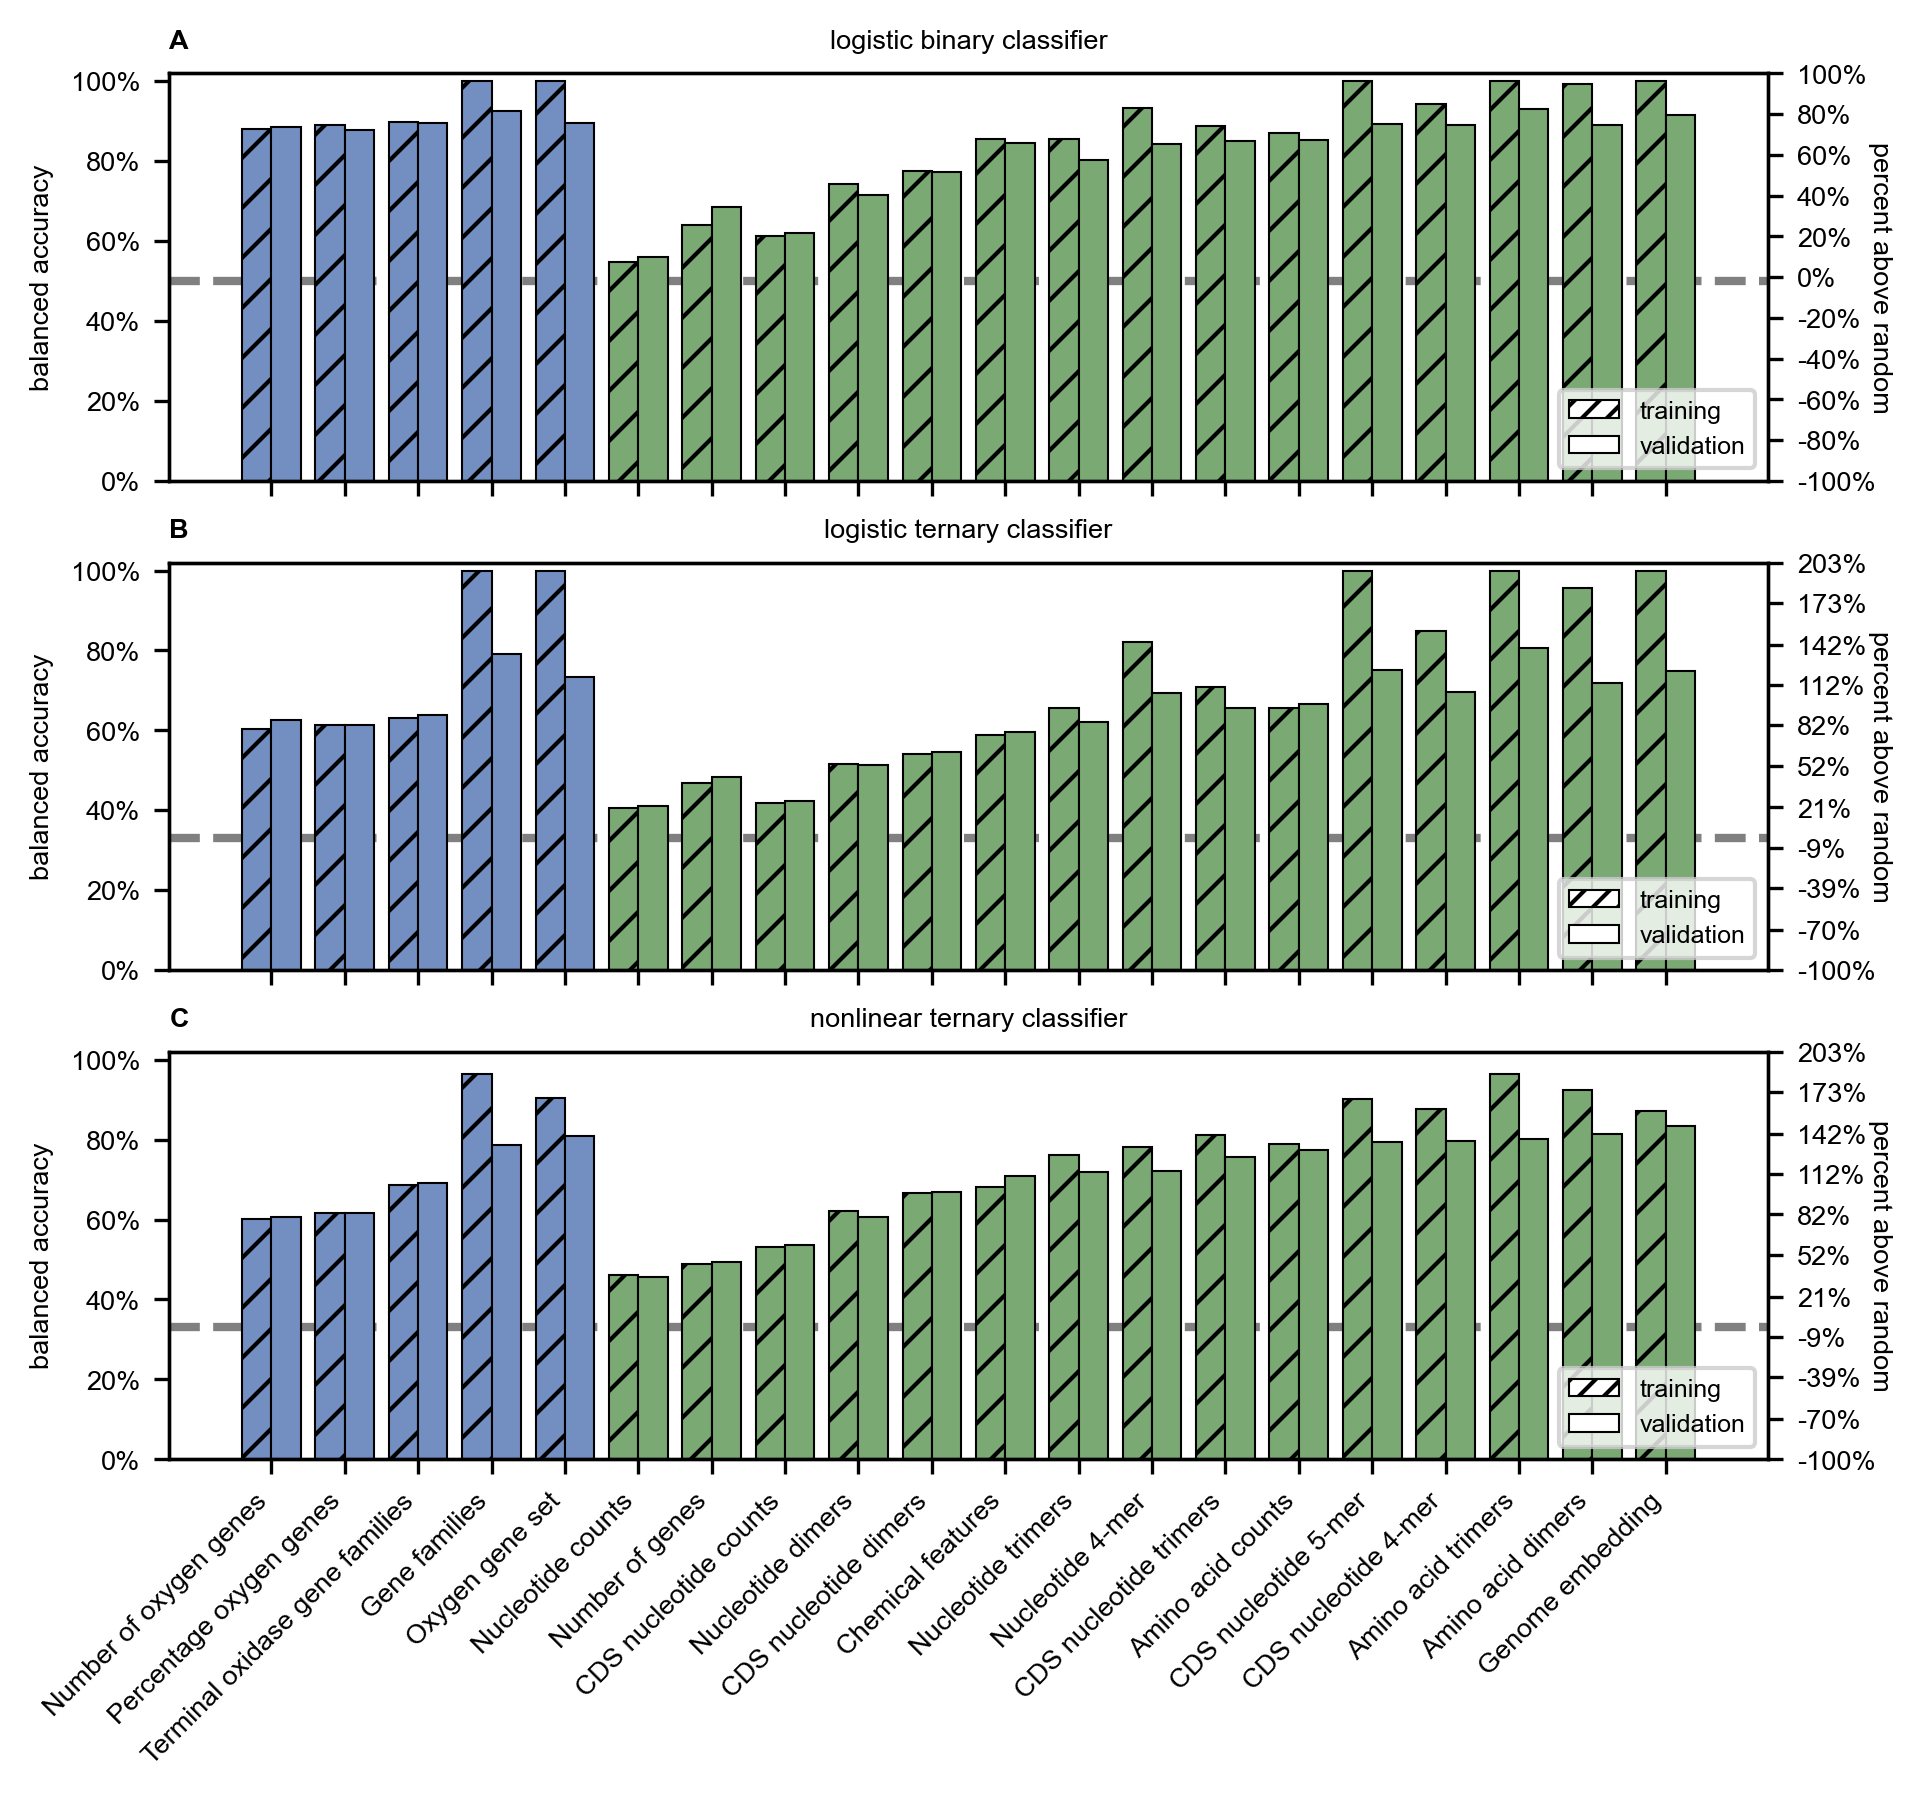

In [12]:
#fig = plt.figure(figsize=(15, 3))
fig = plt.figure()
grid = GridSpec(3, 1, wspace=0.25, )

axes = []

# Enforce same order for all the plots
order_by = {f:r['validation_acc'] for f, r in nonlinear_results_ternary.items()}
axes.append(plot_si_figure_2a(logistic_results_binary, order_by, grid=grid[0, 0], fig=fig))
axes.append(plot_si_figure_2b(logistic_results_ternary, order_by, grid=grid[1, 0], fig=fig))
axes.append(plot_si_figure_2c(nonlinear_results_ternary, order_by, grid=grid[2, 0], fig=fig))

for ax, ax_label in zip(axes, 'ABC'):
    ax.set_title(ax_label, loc='left', fontweight='bold')
    if ax != axes[-1]:
        ax.set_xlabel('')
        ax.set_xticklabels([])

plt.savefig('../results/figures/si_fig2.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()
